# Dati regionali generali

In [102]:
import json
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook

# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# Aggiornare con il proprio path locale
prociv_repo_dir = "/media/michele/DATA-2/Covid/prociv-covid"

Lettura dati Istat sulla popolazione

In [103]:
popolazione = pd.read_csv(os.path.join("dati_aggiuntivi", "popolazione_istat_2020.csv"))
popolazione.head()

,Zona,Popolazione
0,Italia,59641488
1,Piemonte,4311217
2,Torino,2230946
3,Vercelli,169390
4,Novara,364980


Lettura dati Protezione Civile

In [104]:
dati_regioni_csv = os.path.join(prociv_repo_dir, "dati-regioni/dpc-covid19-ita-regioni.csv")
andamento_regioni = pd.read_csv(dati_regioni_csv, parse_dates=[0])
andamento_regioni.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
0,2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-24 18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-24 18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-24 18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
andamento_regioni.columns

Index(['data', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido', 'codice_nuts_1', 'codice_nuts_2'],
      dtype='object')

In [106]:
f"Aggiornato al {andamento_regioni['data'].max()}"

'Aggiornato al 2021-03-14 17:00:00'

### Selezione regione

In [107]:
regione = "Toscana"
andamento_regionale = andamento_regioni[andamento_regioni["denominazione_regione"] == regione]
popolazione_regione = int(popolazione[popolazione["Zona"] == regione]["Popolazione"])
print(f"Regione selezionata {regione}, popolazione {popolazione_regione}")

Regione selezionata Toscana, popolazione 3692555


### Smoothing e aggregazione

Calcolo deceduti su base giornaliera

In [108]:
andamento_regionale['deceduti_giornalieri'] = andamento_regionale.deceduti.diff()

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Smoothing 7, periodicità settimanale per i positivi

In [109]:
andamento_regionale['nuovi_positivi_mov_avg'] = andamento_regionale['nuovi_positivi'].rolling(7).mean()

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Smoothing necessario anche per i deceduti, si riusa 7 per comodità

In [110]:
andamento_regionale['deceduti_giornalieri_mov_avg'] = andamento_regionale['deceduti_giornalieri'].rolling(7).mean()

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Nuovi positivi settimanali per 100 000 abitanti

In [111]:
andamento_regionale['nuovi_positivi_settimanali_centomila_abitanti'] = andamento_regionale['nuovi_positivi'].rolling(7).sum() * 100000 / popolazione_regione

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Andamento dall'inizio

<IPython.core.display.Javascript object>


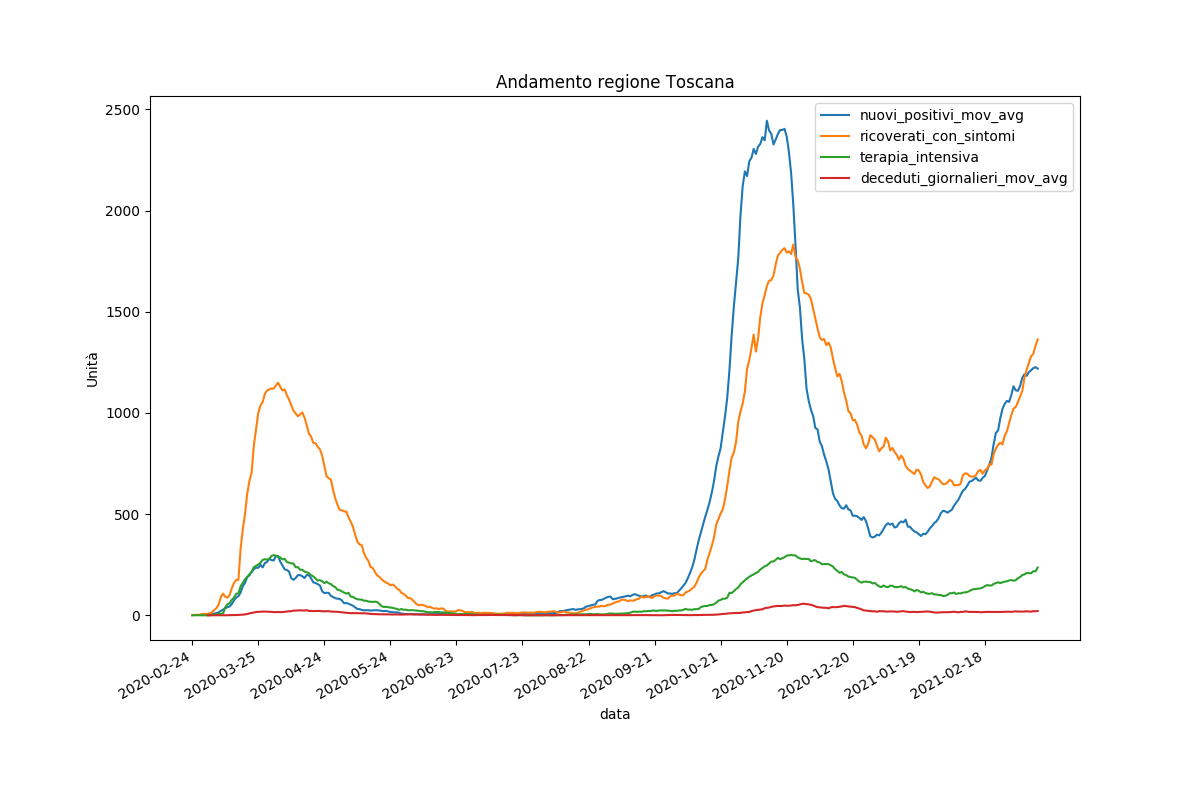

In [112]:
sampling_x = [data for ix, data in enumerate(andamento_regionale["data"]) if ix % 30 == 0]
andamento_regionale.plot(
    x="data",
    xticks=sampling_x,
    y=["nuovi_positivi_mov_avg", "ricoverati_con_sintomi", "terapia_intensiva", "deceduti_giornalieri_mov_avg"],
    title=f"Andamento regione {regione}",
    ylabel="Unità",
    figsize=[12, 8]
);

### Filtro data

Analisi dati a partire dalla seconda ondata dove si ha maggiore copertura e affidabilità nella raccolta dati

In [113]:
primo_ottobre = "2020-10-01 18:00:00"
inizio_zone_di_colore = "2020-11-06 18:00:00"  # DPCM 4 novembre 2020
filtro_data = primo_ottobre

Tutte le metriche

<IPython.core.display.Javascript object>


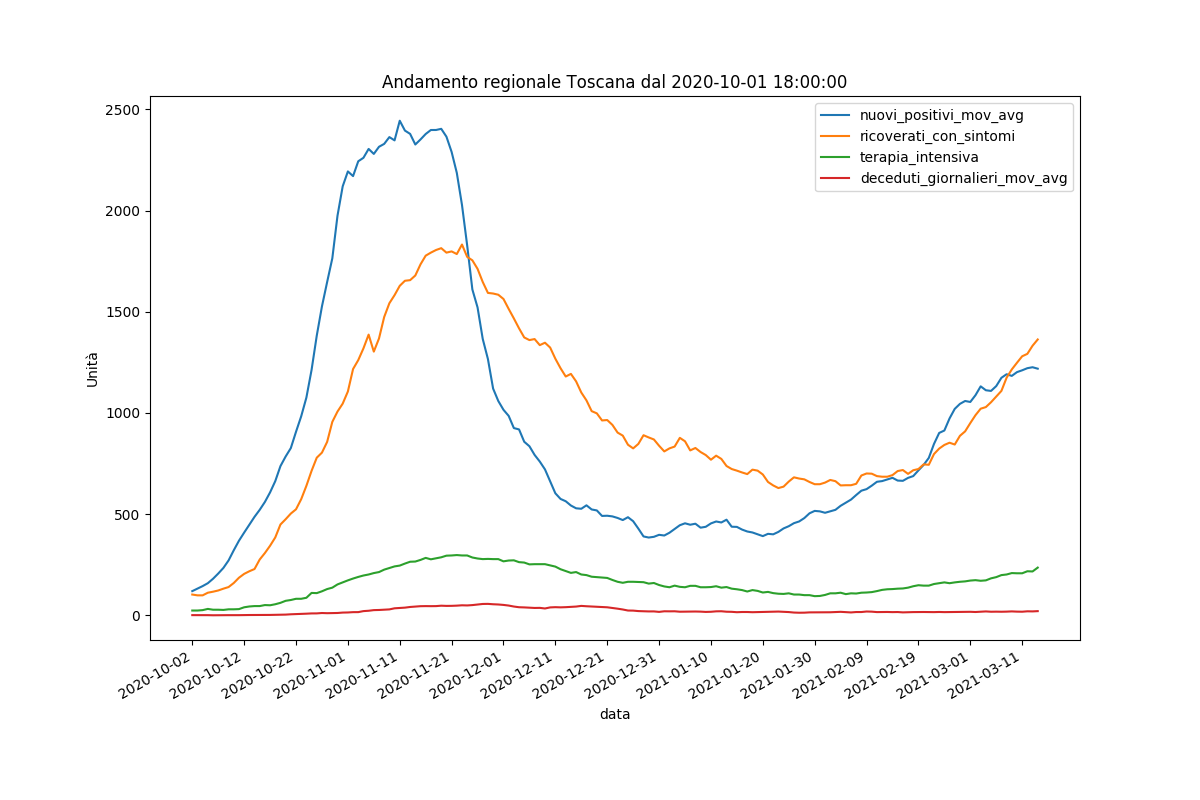

In [114]:
andamento_regionale_filtrato = andamento_regionale[andamento_regionale["data"] > filtro_data]
sampling_filtrato_x = [data for ix, data in enumerate(andamento_regionale_filtrato["data"]) if ix % 10 == 0]
andamento_regionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["nuovi_positivi_mov_avg", "ricoverati_con_sintomi", "terapia_intensiva", "deceduti_giornalieri_mov_avg"],
    title=f"Andamento regionale {regione} dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
);

Terapia intensiva e decessi

<IPython.core.display.Javascript object>


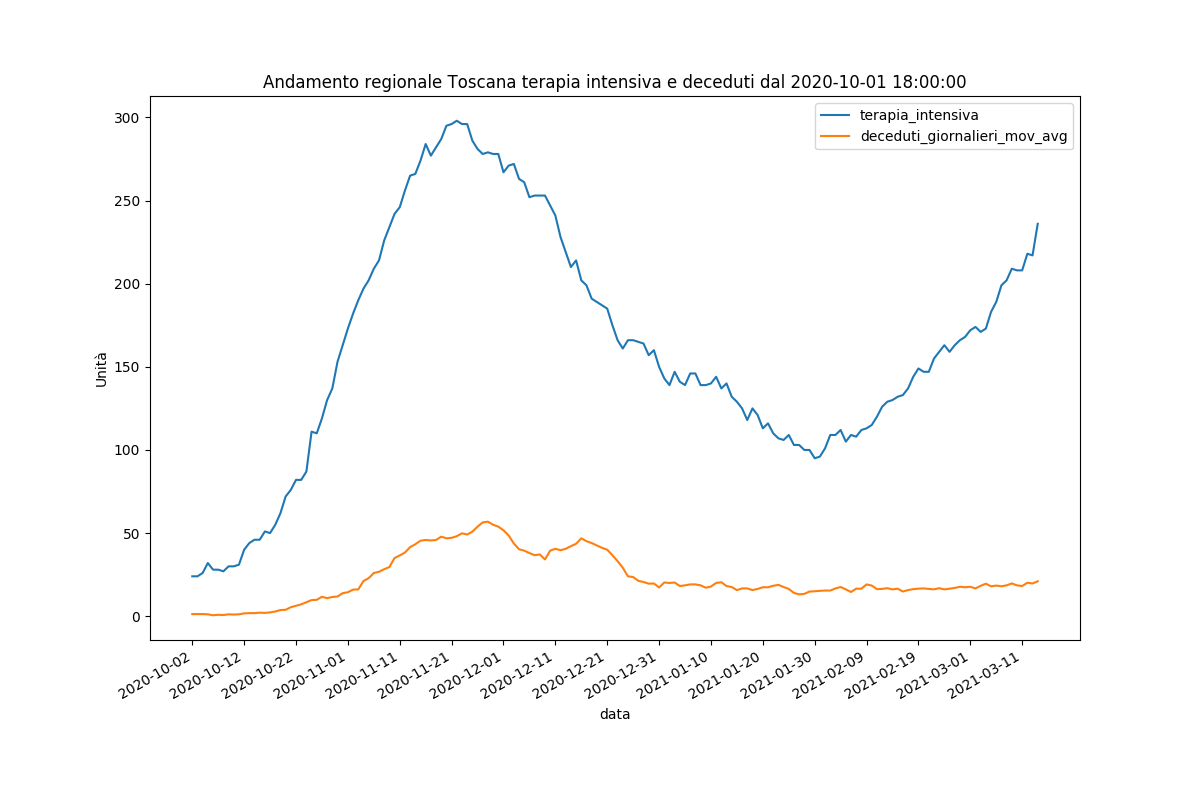

In [115]:
andamento_regionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["terapia_intensiva", "deceduti_giornalieri_mov_avg"],
    title=f"Andamento regionale {regione} terapia intensiva e deceduti dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
);

Nuovi positivi settimanali per centomila abitanti

<IPython.core.display.Javascript object>


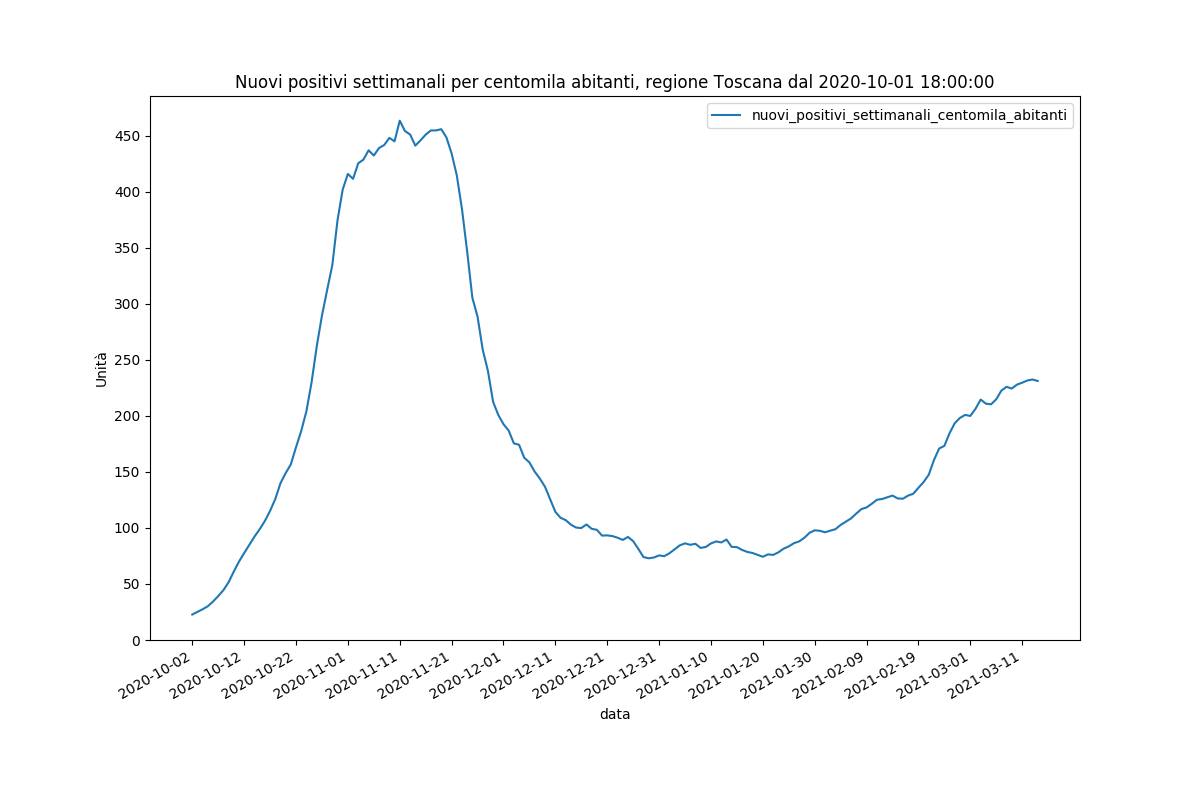

In [116]:
sampling_y = range(0, int(andamento_regionale_filtrato["nuovi_positivi_settimanali_centomila_abitanti"].max()), 50)
andamento_regionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    yticks=sampling_y,
    y=["nuovi_positivi_settimanali_centomila_abitanti"],
    title=f"Nuovi positivi settimanali per centomila abitanti, regione {regione} dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
);

TODO:
- Colorare lo sfondo in orizzontale in base alle soglie rispetto all'indicatore / tracciare linee orizzontale in prossimità dei punti di cambio colore

### Normalizzazione

In [117]:
colonne_da_normalizzare = ["nuovi_positivi_mov_avg", "ricoverati_con_sintomi", "terapia_intensiva", "deceduti_giornalieri_mov_avg"]
for colonna_norm in colonne_da_normalizzare:
    andamento_regionale_filtrato[colonna_norm + "_norm"] = \
        (andamento_regionale_filtrato[colonna_norm] - andamento_regionale_filtrato[colonna_norm].min()) / \
        (andamento_regionale_filtrato[colonna_norm].max() - andamento_regionale_filtrato[colonna_norm].min())

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<IPython.core.display.Javascript object>


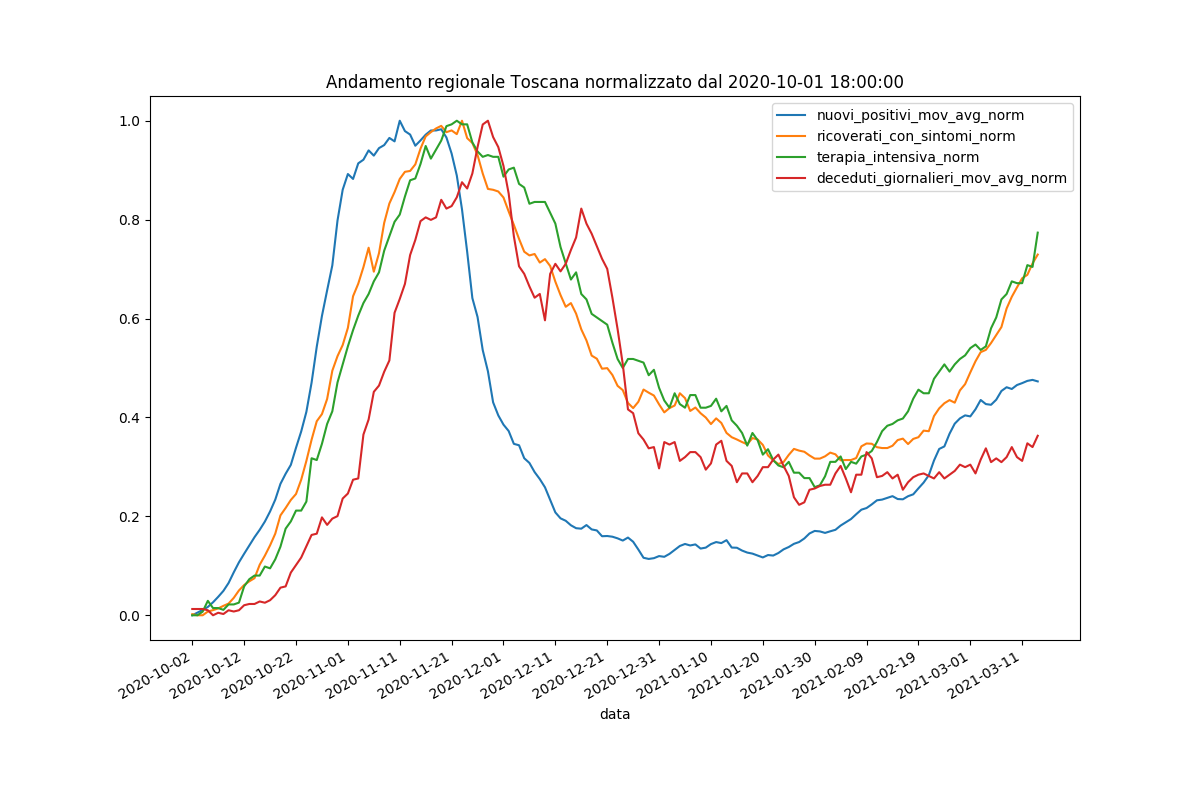

In [118]:
andamento_regionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["nuovi_positivi_mov_avg_norm", "ricoverati_con_sintomi_norm", "terapia_intensiva_norm", "deceduti_giornalieri_mov_avg_norm"],
    title=f"Andamento regionale {regione} normalizzato dal {filtro_data}",
    figsize=[12, 8]
);

# Zone di colore

In [119]:
f"Inizio applicazione zone di colore {inizio_zone_di_colore}"

'Inizio applicazione zone di colore 2020-11-06 18:00:00'

TODO:
- Provare a colorare il grafico in base all'introduzione delle zone
- Ci sono a volte doppie assegnazioni allo stesso giorno, indagare meglio
- Considerare periodo di Natale zona rossa

In [120]:
aree_json_file = os.path.join(prociv_repo_dir, "aree/geojson/dpc-covid-19-aree-nuove-g.json")
with open(aree_json_file) as input_fp:
    aree_json = json.load(input_fp)

In [121]:
for area in aree_json["features"]:
    if area["properties"]["nomeTesto"] == regione:
        #print(area["properties"])
        print(f"Inizio {area['properties']['datasetIni']} {area['properties']['legSpecRif']} fine stimata {area['properties']['datasetFin']}")

Inizio 10/11/2020 art.2 fine stimata 24/11/2020
Inizio 15/11/2020 art.3 fine stimata 29/11/2020
Inizio 15/11/2020 art.3 fine stimata 03/12/2020
Inizio 06/12/2020 art.2 fine stimata 20/12/2020
Inizio 06/12/2020 art.1 fine stimata 20/12/2020
Inizio 10/01/2021 art.1 fine stimata 15/01/2021
Inizio 16/01/2021 art.1 fine stimata 05/03/2021
Inizio 14/02/2021 art.2 fine stimata 28/02/2021
Inizio 01/03/2021 art.2 fine stimata 15/03/2021
